In [26]:
import os

import matplotlib.pyplot as plt
import imageio
import numpy as np
from skimage.filters import threshold_otsu
from skimage.exposure import rescale_intensity

In [10]:
# To generate dataset.py
def get_images(tiles_dir, amount):
    images = []
    for tile in os.listdir(tiles_dir):
        current_tile = tiles_dir + f"/{tile}/"
        images_path = current_tile + "images/"
        for image_uri in os.listdir(images_path):
            img = imageio.imread(images_path + image_uri)

            images.append(img)
            amount -= 1
            if amount <= 0:
                break
        if amount <= 0:
            break

    return images

In [27]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

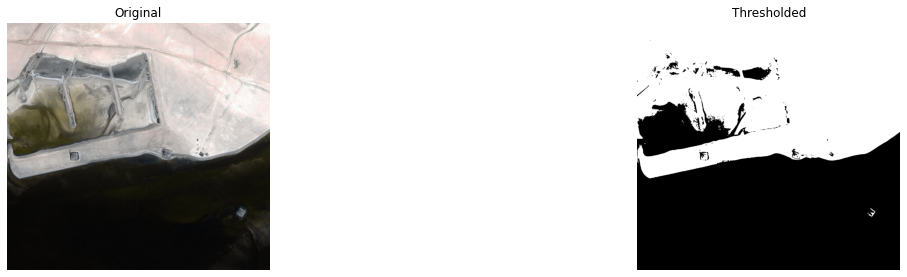

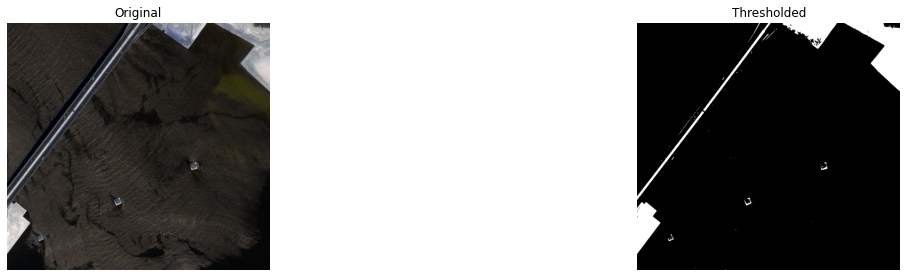

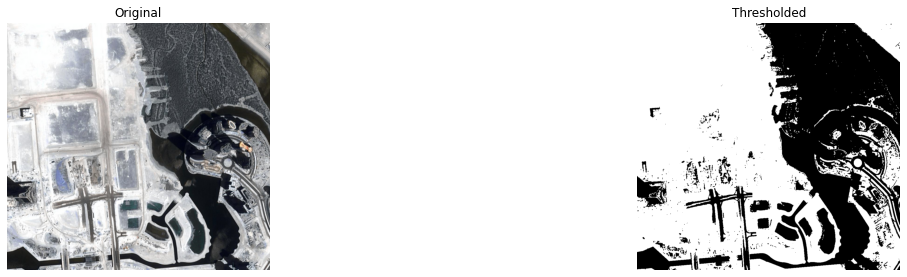

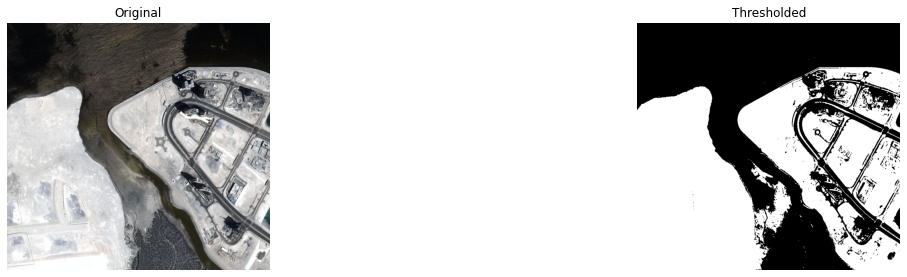

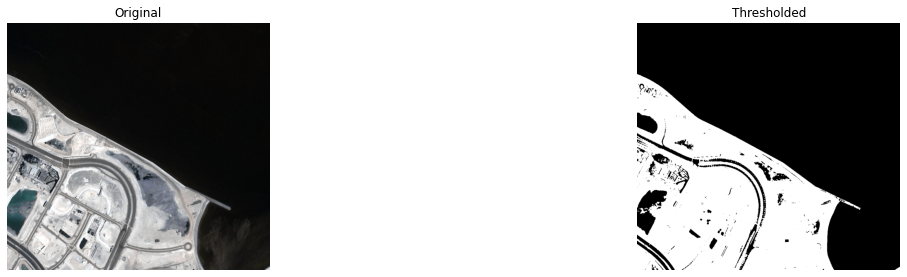

In [32]:
def main():
    images = get_images("data/processed", 5)
    for image in images:
        thresh = threshold_otsu(rgb2gray(image))
        binary= rgb2gray(image) > thresh

        fig, axes = plt.subplots(ncols=2, figsize=(16, 16))
        ax = axes.ravel()
        ax[0] = plt.subplot(1, 3, 1)
        ax[1] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[0].set_title('Original')
        ax[0].axis('off')

        ax[1].imshow(binary, cmap=plt.cm.gray)
        ax[1].set_title('Otsu threshold')
        ax[1].axis('off')

plt.show()
main()